In [127]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

(481, 321, 3)


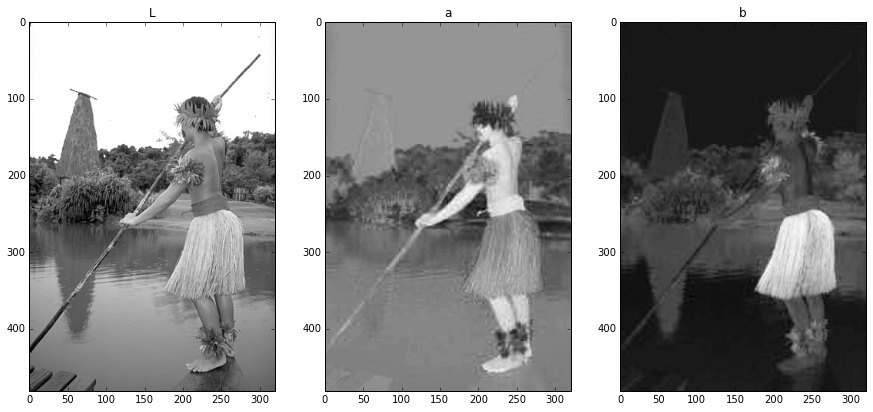

In [146]:
from skimage import io, color
import pylab as pl
%matplotlib inline

rgb = io.imread('test.jpg')
lab = color.rgb2lab(rgb)
fig, ax = pl.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(lab[:,:,0], cmap='gray')
ax[1].imshow(lab[:,:,1], cmap='gray')
ax[2].imshow(lab[:,:,2], cmap='gray')
ax[0].set_title("L")
ax[1].set_title("a")
ax[2].set_title("b")

print lab.shape

8 oriented even- and odd-symmetric Gaussian derivative filters


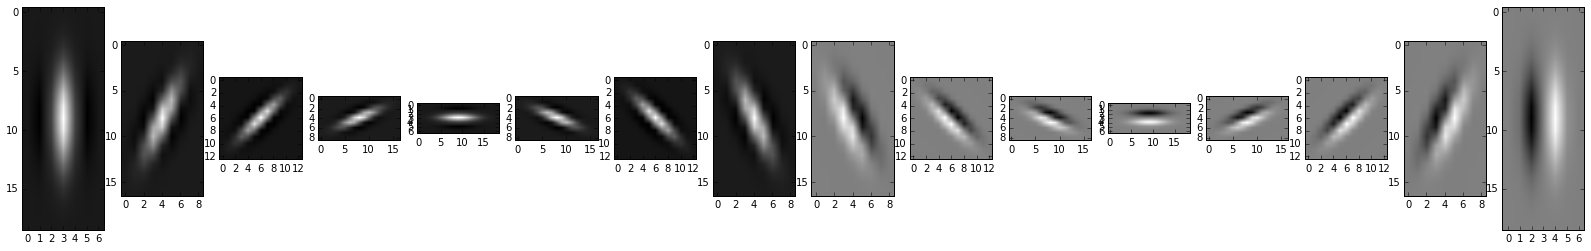

In [161]:
from skimage.filters import gabor_kernel
from scipy.ndimage.filters import gaussian_filter
import numpy as np
import pylab as pl
import math
from scipy.signal import convolve2d
%matplotlib inline

def gabor_kernels(sigma, frequency ):
    filters = []
    for theta in np.arange(0, np.pi, np.pi / 8):
        filters.append(gabor_kernel(frequency, theta ,sigma, sigma))
    return filters

sigma = 1.
frequency = 0.2

gray = rgb2gray(rgb)
filters = gabor_kernels(sigma,frequency)


fig, ax = pl.subplots(1, 16, figsize=(28, 28))
i = 0 
for pic in filters:
    ax[i].imshow(pic.real,cmap = 'gray')
    ax[15-i].imshow(pic.imag,cmap = 'gray')
    i+=1
print '8 oriented even- and odd-symmetric Gaussian derivative filters'

labt = []
for kernel in filters:
    labt.append( convolve2d(gray, np.real(kernel), mode='same', boundary  ='wrap'))

for kernel in filters:
    labt.append(convolve2d(gray, np.imag(kernel), mode='same', boundary  ='wrap'))

labt.append(gaussian_filter(gray, sigma) - gaussian_filter(gray, sigma/math.sqrt(2)))

        




In [130]:
from scipy.cluster.vq import vq, kmeans2, whiten
labt = whiten(labt.T)
c, T = kmeans2(labt, 32, minit='points')

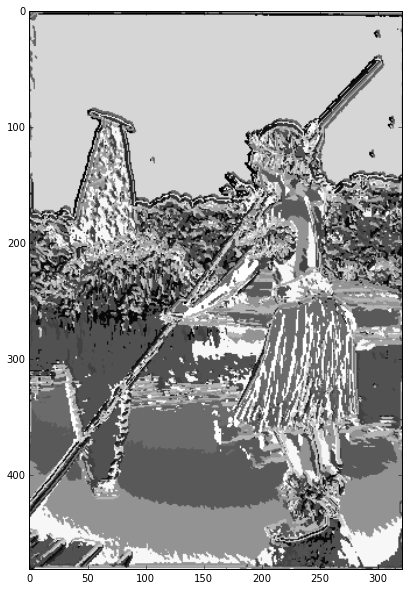

In [131]:
M = T.reshape(picc, -1)
pl.figure (figsize=(10,10))
pl.imshow(M.T,cmap = 'gray')
pl.show()

In [132]:
M = M.T.reshape((picr,picc,1), order ='f')
image = np.concatenate((lab,M), axis=2)

In [133]:
from scipy.signal import savgol_filter

def make_f(r,theta):
    d = 2
    ra = r;
    rb = ra / 4;
    rb = max(1.5, rb);
    ira2 = 1 / ra**2;
    irb2 = 1 / rb**2;
    wr = int(max(ra, rb));
    wd = 2*wr+1;
    sint = np.sin(theta);
    cost = np.cos(theta);
    
    #1. compute linear filters for coefficients
    # (a) compute inverse of least-squares problem matrix
    filt = np.zeros((wd,wd,d+1))
    xx = np.zeros((2*d+1))
    for u in range (-wr, wr):
        for v in range (-wr, wr):
            ai = -u*sint + v*cost; # distance along major axis
            bi = u*cost + v*sint; # distance along minor axis
            if ai*ai*ira2 + bi*bi*irb2 > 1:
                    continue
            else:
                c = np.concatenate((np.array([1]).reshape(1,1),ai+np.zeros((2*d,1))))
                xx = xx + np.cumprod(c)
    A = np.zeros((d+1,d+1))
    for i in range(d+1):
        A[:,i] = xx[i:i+d+1]
        
    # (b) solve least-squares problem for delta function at each pixel
    for u  in range (-wr, wr):
        for v  in range (-wr, wr):
            ai = -u*sint + v*cost; # distance along major axis
            bi = u*cost + v*sint; # distance along minor axis
            if (ai*ai*ira2 + bi*bi*irb2) > 1:
                continue
            else:
                c = np.concatenate((np.array([1]).reshape(1,1),ai+np.zeros((d,1))))
                yy = np.cumprod(c)
                filt[v+wr+1,u+wr+1,:] = np.linalg.solve(A,yy);
    return filt


def fitparab(layer,ra,rb,filt):
    conv = convolve2d(layer,filt[:,:,2], mode = 'same', boundary  ='wrap')
    G = savgol_filter(conv, window_length = ra, polyorder = ra-1, axis = 0, mode='wrap')
    G = savgol_filter(G, window_length = ra, polyorder = ra -1, axis = 1, mode='wrap')
    return G


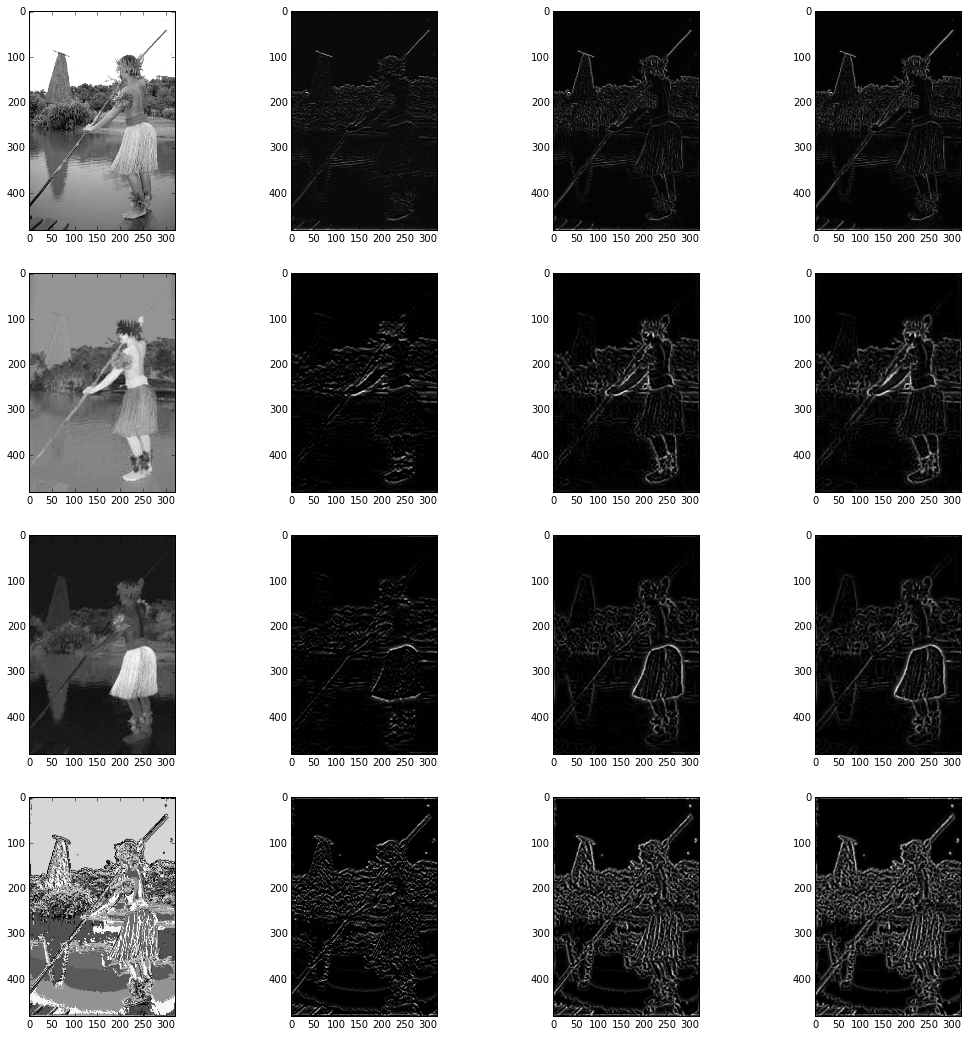

In [163]:
l1 = []
l2 = []
l3 = [] 
a1 = []
a2 = []
a3 = []
b1 = []
b2 = []
b3 = []
t1 = []
t2 = []
t3 = []
fig, ax = pl.subplots(4, 4, figsize=(18, 18))
ax[0][0].imshow(image[:,:,0],cmap = 'gray')
ax[1][0].imshow(image[:,:,1],cmap = 'gray')
ax[2][0].imshow(image[:,:,2],cmap = 'gray')
ax[3][0].imshow(image[:,:,3],cmap = 'gray')

for th in np.arange(0, np.pi, np.pi / 8):
    l1.append(fitparab(image[:,:,0],3,3., make_f(3,th)))
    l2.append(fitparab(image[:,:,0],5,5.,make_f(5,th)))
    l3.append(fitparab(image[:,:,0],11,11.,make_f(10,th)))
    if th == 0:
            ax[0][1].imshow(np.array(l1+l2+l3).max(0),cmap = 'gray')
    if th == np.pi/2:
            ax[0][2].imshow(np.array(l1+l2+l3).max(0),cmap = 'gray')
            
    a1.append(fitparab(image[:,:,1],5,5.,make_f(5,th)))
    a2.append(fitparab(image[:,:,1],11,11.,make_f(10,th)))
    a3.append(fitparab(image[:,:,1],21,21.,make_f(20,th)))
    if th == 0:
            ax[1][1].imshow(np.array(a1+a2+a3).max(0),cmap = 'gray')
    if th == np.pi/2:
            ax[1][2].imshow(np.array(a1+a2+a3).max(0),cmap = 'gray')

    b1.append(fitparab(image[:,:,2],5,5.,make_f(5,th)))
    b2.append(fitparab(image[:,:,2],11,11.,make_f(10,th)))
    b3.append(fitparab(image[:,:,2],21,21.,make_f(20,th)))
    if th == 0:
            ax[2][1].imshow(np.array(b1+b2+b3).max(0),cmap = 'gray')
    if th == np.pi/2:
            ax[2][2].imshow(np.array(b1+b2+b3).max(0),cmap = 'gray')

    t1.append(fitparab(image[:,:,3],5,5.,make_f(5,th)))
    t2.append(fitparab(image[:,:,3],11,11.,make_f(10,th)))
    t3.append(fitparab(image[:,:,3],21,21.,make_f(20,th)))
    if th == 0:
            ax[3][1].imshow(np.array(t1+t2+t3).max(0),cmap = 'gray')
    if th == np.pi/2:
            ax[3][2].imshow(np.array(t1+t2+t3).max(0),cmap = 'gray')


ax[0][3].imshow(np.array(l1+l2+l3).max(0),cmap = 'gray')           
ax[1][3].imshow(np.array(a1+a2+a3).max(0),cmap = 'gray')       
ax[2][3].imshow(np.array(b1+b2+b3).max(0),cmap = 'gray')            
ax[3][3].imshow(np.array(t1+t2+t3).max(0),cmap = 'gray')


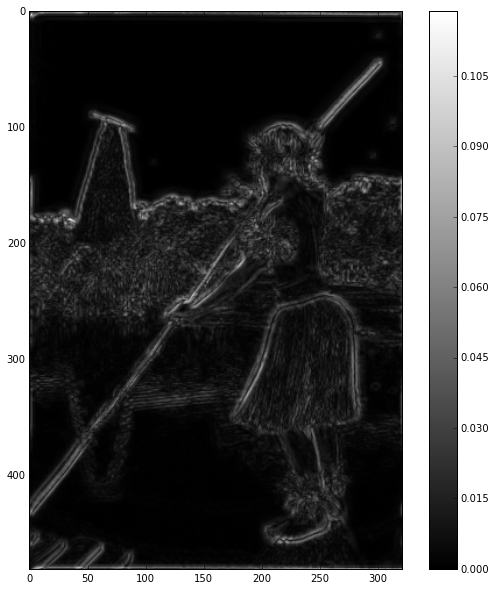

In [135]:
w = [0.0146,0.0145,0.0163,0.0210,0.0243,0.0287,0.0166,0.0185,0.0204,0.0101,0.0111,0.0141]
#w = [0.0245,0.0220,0.0233,0,0,0,0,0,0,0.0208,0.0210,0.0229]
import matplotlib as m

mpb_oriented =  w[0]*np.array(l1)+ w[1]*np.array(l2) + w[2]*np.array(l3) +\
                w[3]*np.array(a1)+ w[4]*np.array(a2) + w[5]*np.array(a3) +\
                w[6]*np.array(b1) + w[7]*np.array(b2) +  w[8]*np.array(b3)+\
              w[9]*np.array(t1) + w[10]*np.array(t2) + w[11]*np.array(t3)

            
mpb_oriented = mpb_oriented - mpb_oriented.mean(0)
mpb =  mpb_oriented .max(0)
pl.figure(figsize =(10,10))
pl.imshow(mpb,cmap = 'gray')
pl.colorbar()
pl.show()

In [164]:

from scipy.sparse import coo_matrix 
def bresenham(i1,j1,i2,j2):
    result = []
    i = float(i1)
    j = float(j1)
    if j2 == j1:
        di = np.sign(i2-i1)
        dj = 0
    else:
        di = float(i2-i1)/abs(j2-j1)
        if abs(di)>1:
            di = np.sign(di)
        if di == 0:
            dj = np.sign(j2-j1)
        else:
            dj = float(j2-j1)/abs(i2-i1)
            if abs(dj)>1:
                dj = np.sign(dj)
    for it in xrange(max(abs(i2-i1),abs(j2-j1))+1):
        result.append( (round(i),round(j)) )
        i += di
        j += dj
    return result
                
def W_for_cell(matrix, i, j,data, row, col):
    n = matrix.shape[0]
    m = matrix.shape[1]
    for ii in xrange(max(i-5,0),min(i+6,11)):
        for jj in xrange(max(j-5,0),min(j+6,11)):
            line = []
            coords = bresenham(ii,jj,i,j)
            for k in coords:
                line.append(matrix[k])
            max_v = max(line) 
            data.append(1- np.exp(-max_v/0.1))
            row.append(i*m+j)
            col.append(ii*m+jj)

def make_W(matrix):
    n = matrix.shape[0]
    m = matrix.shape[1]
    data = []
    row = []
    col = []
    for i in xrange(matrix.shape[0]):
        for j in xrange(matrix.shape[1]):
            W_for_cell(matrix, i, j,data,row,col)
    return coo_matrix((data, (row, col)), shape=(n*m, n*m)).tocsc()

(154401, 154401) 11236


/Users/Toma/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


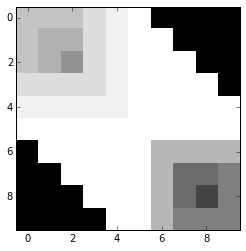

In [165]:
w = make_W(mpb)
print w.shape , w.nnz
ww = w[:10,:10].toarray()
pl.imshow(ww.astype(np.float), interpolation='nearest', cmap = 'gray')


In [166]:
from scipy.sparse import diags
diagonal = np.array(w.sum(axis=1))
D = diags(diagonal.T, [0])

# >>Factor is exactly singular. Why???

In [180]:
import scipy.sparse.linalg
A = D - w
lm, vecs = scipy.sparse.linalg.eigs(A[:100,:100], 1,sigma=0, which='SR', M = D[:100,:100]) 

TypeError: 'dia_matrix' object has no attribute '__getitem__'

In [140]:
pic = vecs[:, 0].reshape(481,-1)
print pic.shape

(11, 11)


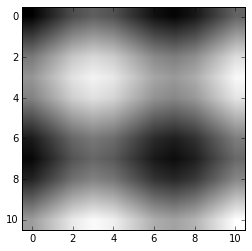

In [141]:
pl.imshow(pic.real, cmap='gray')

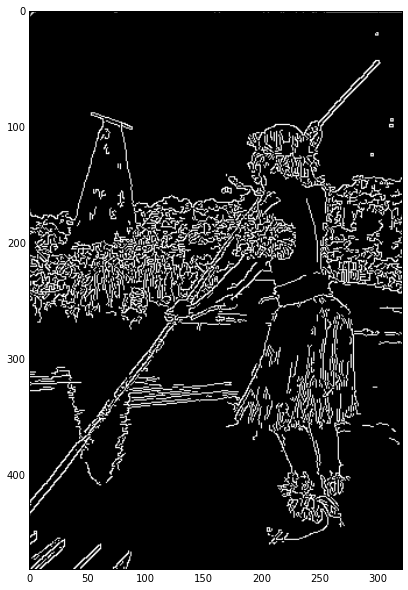

In [147]:
import cv2
img = cv2.cvtColor(rgb,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(img,100,200)
pl.figure(figsize=(10, 10))
pl.imshow(edges,cmap = 'gray')



8 oriented even- and odd-symmetric Gaussian derivative filters and a center-surround (difference of Gaussians) filter


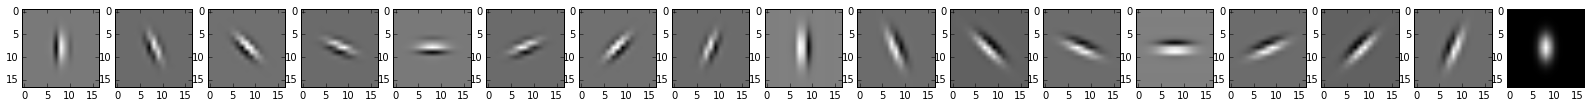

In [154]:
import numpy as np
def build_filters():
    filters = []
    ksize = 17
    for theta in np.arange(0, np.pi, np.pi / 8):
        params = {'ksize':(ksize, ksize), 'sigma':1.0, 'theta': -theta, 'lambd':3,
                  'gamma':0.5, 'psi':4., 'ktype': cv2.CV_64F}
        kern = cv2.getGaborKernel(**params)
        kern /= 2.5*kern.sum()
        filters.append(kern / np.max(np.abs(kern)))
        #print kern[0,0]
        
    for theta in np.arange( 0, np.pi, np.pi / 8):
        params = {'ksize':(ksize, ksize), 'sigma':1.0, 'theta':-theta, 'lambd':4.,
                  'gamma':0.4, 'psi':2, 'ktype': cv2.CV_64F}
        kern = cv2.getGaborKernel(**params)
        kern /= 2.5*kern.sum()
        filters.append(kern / np.max(np.abs(kern)))
        #print kern[0,0]
        
    params = {'ksize':(ksize, ksize), 'sigma':1.0, 'theta':0., 'lambd':1.,
                  'gamma':0.5, 'psi':8., 'ktype': cv2.CV_64F}
    kern = cv2.getGaborKernel(**params)
    kern /= 2.5*kern.sum()
    filters.append(kern / np.max(np.abs(kern)))
    #print kern[0,0]
    return filters


# main
fig, ax = pl.subplots(1, 17, figsize=(28, 28))
i = 0 
filters = build_filters()
for f in filters:
    f = f.astype(np.float)
    ax[i].imshow(f,cmap = 'gray')
    i+=1
print '8 oriented even- and odd-symmetric Gaussian derivative filters and a center-surround (difference of Gaussians) filter'